GDCV_1 : 없다면 어떻게 될까? (ResNet Ablation Study)

<<목차>>

0) 라이브러리 버전 확인하기

1) ResNet 기본 블록 구성하기

2) ResNet-34, ResNet-50 Complete Model

3) 일반 네트워크(plain network) 만들기

4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

5) 루브릭

6) 회고

0) 라이브러리 버전 확인하기

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()


print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2022-11-30 16:20:01.362627: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 16:20:01.676070: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-30 16:20:02.737387: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.7/lib64
2022-11-30 16:20:02.737459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

2.10.0
1.4.2
1.22.4


In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

2022-11-30 16:20:06.159906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 16:20:06.200414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 16:20:06.200588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
BATCH_SIZE = 16  # 256
EPOCHS = 10  # 15
LR = 0.01
OPT_DECAY = 0.0001
MOMENTUM = 0.9
L2_WEIGHT_DECAY = 1e-4
BATCH_NORM_DECAY = 0.9
BATCH_NORM_EPSILON = 1e-5

ACTIVATION = 'sigmoid'
NUM_CLASSES = 1

In [16]:
# tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [17]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [18]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [19]:
ds_info.features["label"].num_classes  # 2

2

In [20]:
ds_info.features["label"].names  # ['cat', 'dog']

['cat', 'dog']

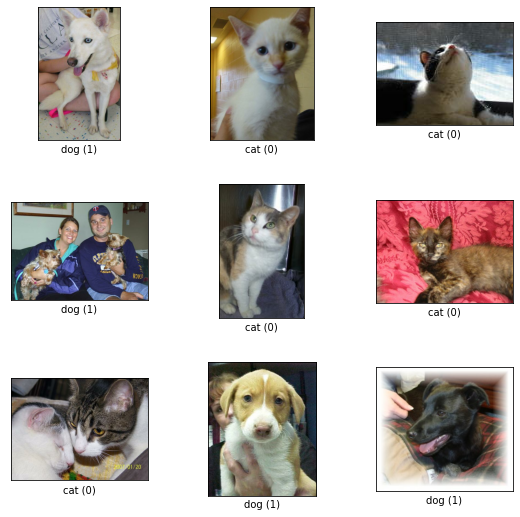

In [21]:
fig = tfds.show_examples(ds_train, ds_info)

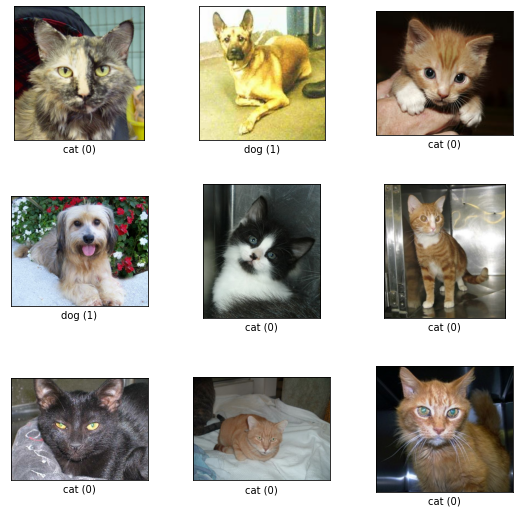

In [22]:
fig = tfds.show_examples(ds_test, ds_info)

In [23]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [24]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [25]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [26]:
for input in ds_train.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


1) ResNet 기본 블록 구성하기

In [27]:
def conv_block(input_layer, 
                channel, 
                kernel_size, 
                strides=1, 
                activation='relu',
                l2_weight_decay=1e-4,
                batch_norm_decay=0.9,
                batch_norm_epsilon=1e-5):
    
    x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=kernel_size,
        kernel_initializer='he_normal',
        kernel_regularizer=keras.regularizers.l2(l2_weight_decay),
        padding='same',
        strides=strides,
        use_bias=False,
    )(input_layer)
    
    x = keras.layers.BatchNormalization(
        # momentum=batch_norm_decay,
        # epsilon=batch_norm_epsilon,
    )(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [29]:
def build_net_block(input_layer, 
                    cnn_count=3, 
                    channel=64, 
                    block_num=0, 
                    is_50=True,
                    is_ResNet=True):

    x = input_layer
    
    # 첫 번째 conv_layer 에서 strides=2 설정해서 너비와 높이를 줄임
    # => 필터의 개수(=채널)가 증가할 때마다 너비와 높이를 줄임

    # ResNet-50, Plain-50
    if is_50:
        if is_ResNet: # ResNet-50
            for i in range(cnn_count):
                if i == 0:
                    shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-50
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (1,1), strides=2)
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
                else:
                    x = conv_block(x, channel, (1,1))
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel*4, (1,1))
    # ResNet-34, Plain-34
    else:
        if is_ResNet:  # ResNet-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3), activation=None)
                else:
                    shortcut = x
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3), activation=None)
                
                x = keras.layers.Add()([x, shortcut])
                x = keras.layers.Activation('relu')(x)
        else:  # Plain-34
            for i in range(cnn_count):
                if block_num > 0 and i == 0:
                    x = conv_block(x, channel, (3,3), strides=2)
                    x = conv_block(x, channel, (3,3))
                else:
                    x = conv_block(x, channel, (3,3))
                    x = conv_block(x, channel, (3,3))

    return x

In [30]:
def build_net(input_shape=(32,32,3),
                cnn_count_list=[3,4,6,3],
                channel_list=[64,128,256,512],
                num_classes=10, 
                is_50=True,
                is_ResNet=True,
                activation='softmax',
                name='ResNet_50'):
    
    # 모델 생성 전, config list들이 같은 길이인지 확인
    assert len(cnn_count_list) == len(channel_list)
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer 설정
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서
    # - is_ResNet=True 일 경우, Residual block 블록을 생성합니다.
    # - is_ResNet=False 일 경우, Plain block 블록을 생성합니다.
    for block_num, (cnn_count, channel) in enumerate(zip(cnn_count_list, channel_list)):
        x = build_net_block(x, 
                            cnn_count=cnn_count, 
                            channel=channel, 
                            block_num=block_num, 
                            is_50=is_50,
                            is_ResNet=is_ResNet)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                        activation=activation, 
                        kernel_initializer='he_normal'
                        )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

2) ResNet-34, ResNet-50 Complete Model

In [31]:
resnet_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_34',
)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

In [32]:
resnet_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=True,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='ResNet_50',
)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                         

3) 일반 네트워크(plain network) 만들기

In [33]:
plain_34 = build_net(
    input_shape=(224,224,3),
    is_50=False,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_34',
)
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        368

In [34]:
plain_50 = build_net(
    input_shape=(224,224,3),
    is_50=True,
    is_ResNet=False,
    num_classes=NUM_CLASSES,
    activation=ACTIVATION,
    name='Plain_50',
)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        409

4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [35]:
def comile_and_fit(model, ds_train, ds_test, ds_info, learning_rate=0.001, momentum= 0.9, opt_decay=0.0001, batch_size=128, epochs=15):
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=momentum,
            decay=opt_decay,
            clipnorm=1.
        ),
        metrics=['accuracy'],
    )

    history = model.fit(
        ds_train,
        steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['train[80%:]'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history

In [36]:
history_resnet_34 = comile_and_fit(resnet_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10


2022-11-30 16:21:54.434122: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-30 16:21:55.457510: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 193/1163 [===>..........................] - ETA: 1:15 - loss: 2.4894 - accuracy: 0.5398

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 1:10 - loss: 2.4752 - accuracy: 0.5540

 273/1163 [======>.......................] - ETA: 1:09 - loss: 2.4756 - accuracy: 0.5533

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 57s - loss: 2.4596 - accuracy: 0.5653

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 25s - loss: 2.3850 - accuracy: 0.6160

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 859/1163 [=====================>........] - ETA: 23s - loss: 2.3811 - accuracy: 0.6183

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 21s - loss: 2.3801 - accuracy: 0.6190

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 16s - loss: 2.3739 - accuracy: 0.6234

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 16s - loss: 2.3727 - accuracy: 0.6233

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 2.3470 - accuracy: 0.6393

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 109s 86ms/step - loss: 2.3470 - accuracy: 0.6393 - val_loss: 2.2522 - val_accuracy: 0.6773
Epoch 2/10
 180/1163 [===>..........................] - ETA: 1:18 - loss: 2.1860 - accuracy: 0.7296

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:11 - loss: 2.1739 - accuracy: 0.7348

 279/1163 [======>.......................] - ETA: 1:09 - loss: 2.1674 - accuracy: 0.7373

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 57s - loss: 2.1768 - accuracy: 0.7358

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 25s - loss: 2.1272 - accuracy: 0.7624

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 23s - loss: 2.1265 - accuracy: 0.7624

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 21s - loss: 2.1254 - accuracy: 0.7624

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 17s - loss: 2.1228 - accuracy: 0.7640

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 16s - loss: 2.1220 - accuracy: 0.7645

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 2.1067 - accuracy: 0.7693

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 86ms/step - loss: 2.1067 - accuracy: 0.7693 - val_loss: 2.5494 - val_accuracy: 0.5800
Epoch 3/10
 201/1163 [====>.........................] - ETA: 1:15 - loss: 1.9779 - accuracy: 0.8228

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 237/1163 [=====>........................] - ETA: 1:12 - loss: 1.9659 - accuracy: 0.8281

 281/1163 [======>.......................] - ETA: 1:09 - loss: 1.9621 - accuracy: 0.8310

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 57s - loss: 1.9532 - accuracy: 0.8350

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 24s - loss: 1.9273 - accuracy: 0.8405

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 23s - loss: 1.9258 - accuracy: 0.8408

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 21s - loss: 1.9232 - accuracy: 0.8419

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 17s - loss: 1.9178 - accuracy: 0.8443

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 16s - loss: 1.9177 - accuracy: 0.8441

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.9088 - accuracy: 0.8467

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 99s 85ms/step - loss: 1.9088 - accuracy: 0.8467 - val_loss: 2.0829 - val_accuracy: 0.7981
Epoch 4/10
 202/1163 [====>.........................] - ETA: 1:15 - loss: 1.8144 - accuracy: 0.8759

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 249/1163 [=====>........................] - ETA: 1:12 - loss: 1.8132 - accuracy: 0.8760

 281/1163 [======>.......................] - ETA: 1:09 - loss: 1.8105 - accuracy: 0.8786

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 57s - loss: 1.8122 - accuracy: 0.8791

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 25s - loss: 1.7837 - accuracy: 0.8883

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 23s - loss: 1.7812 - accuracy: 0.8889

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 21s - loss: 1.7806 - accuracy: 0.8887

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 17s - loss: 1.7763 - accuracy: 0.8901

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 16s - loss: 1.7761 - accuracy: 0.8902

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.7685 - accuracy: 0.8922

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 86ms/step - loss: 1.7685 - accuracy: 0.8922 - val_loss: 2.1575 - val_accuracy: 0.7381
Epoch 5/10
 200/1163 [====>.........................] - ETA: 1:15 - loss: 1.6922 - accuracy: 0.9128

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:10 - loss: 1.6939 - accuracy: 0.9133

 282/1163 [======>.......................] - ETA: 1:09 - loss: 1.6952 - accuracy: 0.9127

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 57s - loss: 1.6930 - accuracy: 0.9136

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 24s - loss: 1.6728 - accuracy: 0.9196

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 23s - loss: 1.6714 - accuracy: 0.9199

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 21s - loss: 1.6693 - accuracy: 0.9208

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 17s - loss: 1.6653 - accuracy: 0.9216

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 16s - loss: 1.6647 - accuracy: 0.9218

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.6592 - accuracy: 0.9234

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 86ms/step - loss: 1.6592 - accuracy: 0.9234 - val_loss: 1.8003 - val_accuracy: 0.8487
Epoch 6/10
 200/1163 [====>.........................] - ETA: 1:15 - loss: 1.6109 - accuracy: 0.9369

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:10 - loss: 1.6052 - accuracy: 0.9382

 287/1163 [======>.......................] - ETA: 1:08 - loss: 1.6075 - accuracy: 0.9364

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 434/1163 [==========>...................] - ETA: 57s - loss: 1.5968 - accuracy: 0.9398

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 838/1163 [====================>.........] - ETA: 25s - loss: 1.5783 - accuracy: 0.9448

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 22s - loss: 1.5759 - accuracy: 0.9450

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 21s - loss: 1.5751 - accuracy: 0.9454

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 17s - loss: 1.5737 - accuracy: 0.9452

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 16s - loss: 1.5729 - accuracy: 0.9455

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.5648 - accuracy: 0.9468

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 86ms/step - loss: 1.5648 - accuracy: 0.9468 - val_loss: 1.7846 - val_accuracy: 0.8594
Epoch 7/10
 204/1163 [====>.........................] - ETA: 1:15 - loss: 1.5291 - accuracy: 0.9510

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 254/1163 [=====>........................] - ETA: 1:11 - loss: 1.5298 - accuracy: 0.9496

 287/1163 [======>.......................] - ETA: 1:09 - loss: 1.5254 - accuracy: 0.9508

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 57s - loss: 1.5215 - accuracy: 0.9519

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 24s - loss: 1.4954 - accuracy: 0.9609

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 22s - loss: 1.4960 - accuracy: 0.9603

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 886/1163 [=====================>........] - ETA: 21s - loss: 1.4954 - accuracy: 0.9604

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1163 [=======================>......] - ETA: 17s - loss: 1.4952 - accuracy: 0.9602

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 16s - loss: 1.4945 - accuracy: 0.9606

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.4855 - accuracy: 0.9632

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 86ms/step - loss: 1.4855 - accuracy: 0.9632 - val_loss: 2.0639 - val_accuracy: 0.7964
Epoch 8/10
 205/1163 [====>.........................] - ETA: 1:15 - loss: 1.4351 - accuracy: 0.9773

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 1:11 - loss: 1.4322 - accuracy: 0.9788

 285/1163 [======>.......................] - ETA: 1:09 - loss: 1.4318 - accuracy: 0.9793

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 57s - loss: 1.4289 - accuracy: 0.9794

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 24s - loss: 1.4188 - accuracy: 0.9809

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 23s - loss: 1.4182 - accuracy: 0.9810

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 21s - loss: 1.4180 - accuracy: 0.9809

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 16s - loss: 1.4175 - accuracy: 0.9810

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 15s - loss: 1.4172 - accuracy: 0.9809

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.4108 - accuracy: 0.9823

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 86ms/step - loss: 1.4108 - accuracy: 0.9823 - val_loss: 1.6311 - val_accuracy: 0.9073
Epoch 9/10
 204/1163 [====>.........................] - ETA: 1:15 - loss: 1.3874 - accuracy: 0.9825

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 1:10 - loss: 1.3820 - accuracy: 0.9853

 285/1163 [======>.......................] - ETA: 1:09 - loss: 1.3811 - accuracy: 0.9857

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 57s - loss: 1.3818 - accuracy: 0.9853

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1163 [====================>.........] - ETA: 24s - loss: 1.3713 - accuracy: 0.9877

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 23s - loss: 1.3707 - accuracy: 0.9877

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 21s - loss: 1.3698 - accuracy: 0.9880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 16s - loss: 1.3682 - accuracy: 0.9882

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 15s - loss: 1.3681 - accuracy: 0.9882

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.3639 - accuracy: 0.9888

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 86ms/step - loss: 1.3639 - accuracy: 0.9888 - val_loss: 1.6083 - val_accuracy: 0.9190
Epoch 10/10
 204/1163 [====>.........................] - ETA: 1:15 - loss: 1.3487 - accuracy: 0.9884

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 1:10 - loss: 1.3468 - accuracy: 0.9888

 278/1163 [======>.......................] - ETA: 1:09 - loss: 1.3473 - accuracy: 0.9888

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 57s - loss: 1.3404 - accuracy: 0.9902

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 24s - loss: 1.3337 - accuracy: 0.9912

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 23s - loss: 1.3332 - accuracy: 0.9914

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 900/1163 [======================>.......] - ETA: 20s - loss: 1.3319 - accuracy: 0.9917

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 16s - loss: 1.3307 - accuracy: 0.9918

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1163 [=======================>......] - ETA: 15s - loss: 1.3307 - accuracy: 0.9918

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.3264 - accuracy: 0.9926

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 99s 85ms/step - loss: 1.3264 - accuracy: 0.9926 - val_loss: 1.6283 - val_accuracy: 0.9198


In [37]:
history_plain_34 = comile_and_fit(plain_34, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
 185/1163 [===>..........................] - ETA: 1:12 - loss: 2.2572 - accuracy: 0.5176

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 1:06 - loss: 2.2463 - accuracy: 0.5255

 281/1163 [======>.......................] - ETA: 1:04 - loss: 2.2419 - accuracy: 0.5309

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 428/1163 [==========>...................] - ETA: 54s - loss: 2.2307 - accuracy: 0.5356

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 23s - loss: 2.2090 - accuracy: 0.5558

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 22s - loss: 2.2072 - accuracy: 0.5577

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1163 [=====================>........] - ETA: 20s - loss: 2.2058 - accuracy: 0.5592

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 941/1163 [=======================>......] - ETA: 16s - loss: 2.2018 - accuracy: 0.5628

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 15s - loss: 2.2006 - accuracy: 0.5641

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 2.1873 - accuracy: 0.5748

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 100s 81ms/step - loss: 2.1873 - accuracy: 0.5748 - val_loss: 2.2051 - val_accuracy: 0.5789
Epoch 2/10
 195/1163 [====>.........................] - ETA: 1:12 - loss: 2.1098 - accuracy: 0.6321

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:07 - loss: 2.1056 - accuracy: 0.6366

 277/1163 [======>.......................] - ETA: 1:06 - loss: 2.1038 - accuracy: 0.6388

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 54s - loss: 2.0990 - accuracy: 0.6406

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 840/1163 [====================>.........] - ETA: 24s - loss: 2.0745 - accuracy: 0.6565

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 22s - loss: 2.0735 - accuracy: 0.6572

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 20s - loss: 2.0724 - accuracy: 0.6578

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 16s - loss: 2.0709 - accuracy: 0.6584

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 15s - loss: 2.0708 - accuracy: 0.6586

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 2.0609 - accuracy: 0.6631

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 82ms/step - loss: 2.0609 - accuracy: 0.6631 - val_loss: 2.1450 - val_accuracy: 0.6389
Epoch 3/10
 193/1163 [===>..........................] - ETA: 1:12 - loss: 2.0094 - accuracy: 0.6852

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 1:07 - loss: 2.0064 - accuracy: 0.6851

 281/1163 [======>.......................] - ETA: 1:06 - loss: 2.0036 - accuracy: 0.6884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 55s - loss: 1.9930 - accuracy: 0.6895

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 24s - loss: 1.9706 - accuracy: 0.7014

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 22s - loss: 1.9699 - accuracy: 0.7020

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 20s - loss: 1.9680 - accuracy: 0.7030

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 16s - loss: 1.9649 - accuracy: 0.7050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 15s - loss: 1.9641 - accuracy: 0.7055

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.9547 - accuracy: 0.7091

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 82ms/step - loss: 1.9547 - accuracy: 0.7091 - val_loss: 2.0319 - val_accuracy: 0.6332
Epoch 4/10
 193/1163 [===>..........................] - ETA: 1:12 - loss: 1.9043 - accuracy: 0.7293

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:07 - loss: 1.8966 - accuracy: 0.7371

 280/1163 [======>.......................] - ETA: 1:05 - loss: 1.8947 - accuracy: 0.7385

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 54s - loss: 1.8849 - accuracy: 0.7388

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 842/1163 [====================>.........] - ETA: 23s - loss: 1.8615 - accuracy: 0.7500

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 22s - loss: 1.8610 - accuracy: 0.7505

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 20s - loss: 1.8606 - accuracy: 0.7502

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 16s - loss: 1.8586 - accuracy: 0.7511

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 15s - loss: 1.8581 - accuracy: 0.7515

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.8476 - accuracy: 0.7560

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 81ms/step - loss: 1.8476 - accuracy: 0.7560 - val_loss: 1.8713 - val_accuracy: 0.7409
Epoch 5/10
 198/1163 [====>.........................] - ETA: 1:11 - loss: 1.7925 - accuracy: 0.7762

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1163 [=====>........................] - ETA: 1:07 - loss: 1.7914 - accuracy: 0.7764

 280/1163 [======>.......................] - ETA: 1:05 - loss: 1.7903 - accuracy: 0.7741

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 54s - loss: 1.7732 - accuracy: 0.7820

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 23s - loss: 1.7565 - accuracy: 0.7893

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 22s - loss: 1.7557 - accuracy: 0.7897

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 20s - loss: 1.7540 - accuracy: 0.7908

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 16s - loss: 1.7538 - accuracy: 0.7910

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 15s - loss: 1.7529 - accuracy: 0.7916

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.7438 - accuracy: 0.7951

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 82ms/step - loss: 1.7438 - accuracy: 0.7951 - val_loss: 2.2165 - val_accuracy: 0.6406
Epoch 6/10
 196/1163 [====>.........................] - ETA: 1:12 - loss: 1.6888 - accuracy: 0.8208

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 1:07 - loss: 1.6864 - accuracy: 0.8240

 286/1163 [======>.......................] - ETA: 1:05 - loss: 1.6827 - accuracy: 0.8245

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 54s - loss: 1.6779 - accuracy: 0.8263

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 23s - loss: 1.6649 - accuracy: 0.8287

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 21s - loss: 1.6646 - accuracy: 0.8284

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 20s - loss: 1.6642 - accuracy: 0.8277

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 16s - loss: 1.6646 - accuracy: 0.8279

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 15s - loss: 1.6637 - accuracy: 0.8284

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.6531 - accuracy: 0.8322

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 81ms/step - loss: 1.6531 - accuracy: 0.8322 - val_loss: 2.0262 - val_accuracy: 0.6841
Epoch 7/10
 200/1163 [====>.........................] - ETA: 1:12 - loss: 1.6199 - accuracy: 0.8425

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 251/1163 [=====>........................] - ETA: 1:08 - loss: 1.6151 - accuracy: 0.8459

 289/1163 [======>.......................] - ETA: 1:05 - loss: 1.6099 - accuracy: 0.8471

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 54s - loss: 1.5983 - accuracy: 0.8500

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 23s - loss: 1.5793 - accuracy: 0.8551

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 872/1163 [=====================>........] - ETA: 21s - loss: 1.5781 - accuracy: 0.8556

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 20s - loss: 1.5771 - accuracy: 0.8559

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 16s - loss: 1.5762 - accuracy: 0.8569

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 15s - loss: 1.5750 - accuracy: 0.8576

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.5693 - accuracy: 0.8596

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 82ms/step - loss: 1.5693 - accuracy: 0.8596 - val_loss: 1.6591 - val_accuracy: 0.8086
Epoch 8/10
 198/1163 [====>.........................] - ETA: 1:12 - loss: 1.5345 - accuracy: 0.8677

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:07 - loss: 1.5273 - accuracy: 0.8707

 283/1163 [======>.......................] - ETA: 1:05 - loss: 1.5246 - accuracy: 0.8719

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 54s - loss: 1.5150 - accuracy: 0.8777

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 850/1163 [====================>.........] - ETA: 23s - loss: 1.5007 - accuracy: 0.8800

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 21s - loss: 1.5000 - accuracy: 0.8799

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 20s - loss: 1.4981 - accuracy: 0.8807

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 15s - loss: 1.4969 - accuracy: 0.8809

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 15s - loss: 1.4979 - accuracy: 0.8804

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.4939 - accuracy: 0.8797

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 95s 82ms/step - loss: 1.4939 - accuracy: 0.8797 - val_loss: 1.5453 - val_accuracy: 0.8463
Epoch 9/10
 203/1163 [====>.........................] - ETA: 1:11 - loss: 1.4692 - accuracy: 0.8892

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 268/1163 [=====>........................] - ETA: 1:06 - loss: 1.4584 - accuracy: 0.8918

 285/1163 [======>.......................] - ETA: 1:05 - loss: 1.4539 - accuracy: 0.8941

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 437/1163 [==========>...................] - ETA: 54s - loss: 1.4433 - accuracy: 0.8966

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 23s - loss: 1.4328 - accuracy: 0.8983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 21s - loss: 1.4320 - accuracy: 0.8985

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 20s - loss: 1.4315 - accuracy: 0.8989

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 16s - loss: 1.4275 - accuracy: 0.9003

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 15s - loss: 1.4278 - accuracy: 0.9004

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.4242 - accuracy: 0.9008

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 94s 81ms/step - loss: 1.4242 - accuracy: 0.9008 - val_loss: 1.4209 - val_accuracy: 0.8968
Epoch 10/10
 201/1163 [====>.........................] - ETA: 1:11 - loss: 1.3877 - accuracy: 0.9117

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:07 - loss: 1.3835 - accuracy: 0.9131

 290/1163 [======>.......................] - ETA: 1:05 - loss: 1.3789 - accuracy: 0.9155

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 54s - loss: 1.3841 - accuracy: 0.9132

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 23s - loss: 1.3750 - accuracy: 0.9140

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 875/1163 [=====================>........] - ETA: 21s - loss: 1.3752 - accuracy: 0.9134

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 19s - loss: 1.3749 - accuracy: 0.9132

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 951/1163 [=======================>......] - ETA: 15s - loss: 1.3736 - accuracy: 0.9136

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 14s - loss: 1.3724 - accuracy: 0.9142

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 1.3694 - accuracy: 0.9150

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 94s 81ms/step - loss: 1.3694 - accuracy: 0.9150 - val_loss: 1.3980 - val_accuracy: 0.8961


In [38]:
history_resnet_50 = comile_and_fit(resnet_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
 196/1163 [====>.........................] - ETA: 52s - loss: 6.2299 - accuracy: 0.4981

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 49s - loss: 6.2194 - accuracy: 0.5024

 281/1163 [======>.......................] - ETA: 47s - loss: 6.2098 - accuracy: 0.5071

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 39s - loss: 6.1989 - accuracy: 0.5242

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1163 [====================>.........] - ETA: 17s - loss: 6.0947 - accuracy: 0.5535

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 866/1163 [=====================>........] - ETA: 16s - loss: 6.0892 - accuracy: 0.5556

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 889/1163 [=====================>........] - ETA: 14s - loss: 6.0828 - accuracy: 0.5576

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 12s - loss: 6.0762 - accuracy: 0.5611

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 11s - loss: 6.0732 - accuracy: 0.5621

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 6.0448 - accuracy: 0.5701

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 80s 60ms/step - loss: 6.0448 - accuracy: 0.5701 - val_loss: 5.8084 - val_accuracy: 0.6279
Epoch 2/10
 194/1163 [====>.........................] - ETA: 52s - loss: 5.7847 - accuracy: 0.6369

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 256/1163 [=====>........................] - ETA: 49s - loss: 5.7803 - accuracy: 0.6370

 280/1163 [======>.......................] - ETA: 48s - loss: 5.7778 - accuracy: 0.6368

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 431/1163 [==========>...................] - ETA: 39s - loss: 5.7688 - accuracy: 0.6328

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 17s - loss: 5.7225 - accuracy: 0.6498

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 16s - loss: 5.7195 - accuracy: 0.6506

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 15s - loss: 5.7213 - accuracy: 0.6491

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 943/1163 [=======================>......] - ETA: 12s - loss: 5.7153 - accuracy: 0.6510

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 11s - loss: 5.7146 - accuracy: 0.6518

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 5.6884 - accuracy: 0.6595

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 69s 60ms/step - loss: 5.6884 - accuracy: 0.6595 - val_loss: 5.5789 - val_accuracy: 0.6890
Epoch 3/10


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 198/1163 [====>.........................] - ETA: 52s - loss: 5.5038 - accuracy: 0.7033

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 49s - loss: 5.5033 - accuracy: 0.7016

 277/1163 [======>.......................] - ETA: 48s - loss: 5.4995 - accuracy: 0.7031

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 39s - loss: 5.4963 - accuracy: 0.6985

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 17s - loss: 5.4544 - accuracy: 0.7096

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 863/1163 [=====================>........] - ETA: 16s - loss: 5.4515 - accuracy: 0.7104

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 14s - loss: 5.4482 - accuracy: 0.7117

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 944/1163 [=======================>......] - ETA: 11s - loss: 5.4412 - accuracy: 0.7132

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 11s - loss: 5.4400 - accuracy: 0.7132

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 5.4229 - accuracy: 0.7167

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 69s 60ms/step - loss: 5.4229 - accuracy: 0.7167 - val_loss: 5.7112 - val_accuracy: 0.6011
Epoch 4/10


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 196/1163 [====>.........................] - ETA: 52s - loss: 5.2583 - accuracy: 0.7506

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 48s - loss: 5.2722 - accuracy: 0.7387

 282/1163 [======>.......................] - ETA: 47s - loss: 5.2738 - accuracy: 0.7358

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 39s - loss: 5.2774 - accuracy: 0.7310

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 17s - loss: 5.2463 - accuracy: 0.7369

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 16s - loss: 5.2438 - accuracy: 0.7379

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 14s - loss: 5.2390 - accuracy: 0.7398

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 11s - loss: 5.2377 - accuracy: 0.7394

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 11s - loss: 5.2358 - accuracy: 0.7399

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 5.2169 - accuracy: 0.7428

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 70s 60ms/step - loss: 5.2169 - accuracy: 0.7428 - val_loss: 5.9762 - val_accuracy: 0.7396
Epoch 5/10
 197/1163 [====>.........................] - ETA: 52s - loss: 5.0837 - accuracy: 0.7757

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 48s - loss: 5.0783 - accuracy: 0.7761

 286/1163 [======>.......................] - ETA: 47s - loss: 5.0827 - accuracy: 0.7734

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 429/1163 [==========>...................] - ETA: 39s - loss: 5.0737 - accuracy: 0.7720

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 847/1163 [====================>.........] - ETA: 17s - loss: 5.0405 - accuracy: 0.7791

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 15s - loss: 5.0376 - accuracy: 0.7801

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 892/1163 [======================>.......] - ETA: 14s - loss: 5.0347 - accuracy: 0.7812

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 11s - loss: 5.0307 - accuracy: 0.7815

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 959/1163 [=======================>......] - ETA: 11s - loss: 5.0300 - accuracy: 0.7816

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 5.0091 - accuracy: 0.7857

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 69s 60ms/step - loss: 5.0091 - accuracy: 0.7857 - val_loss: 5.3740 - val_accuracy: 0.7556
Epoch 6/10


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 202/1163 [====>.........................] - ETA: 52s - loss: 4.8814 - accuracy: 0.8051

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 261/1163 [=====>........................] - ETA: 49s - loss: 4.8791 - accuracy: 0.8015

 282/1163 [======>.......................] - ETA: 47s - loss: 4.8785 - accuracy: 0.8019

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 432/1163 [==========>...................] - ETA: 39s - loss: 4.8721 - accuracy: 0.8035

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 17s - loss: 4.8542 - accuracy: 0.8037

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 16s - loss: 4.8525 - accuracy: 0.8036

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 14s - loss: 4.8505 - accuracy: 0.8042

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 11s - loss: 4.8483 - accuracy: 0.8042

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 963/1163 [=======================>......] - ETA: 10s - loss: 4.8472 - accuracy: 0.8046

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.8316 - accuracy: 0.8079

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 69s 60ms/step - loss: 4.8316 - accuracy: 0.8079 - val_loss: 5.0353 - val_accuracy: 0.7528
Epoch 7/10


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 204/1163 [====>.........................] - ETA: 51s - loss: 4.7026 - accuracy: 0.8450

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 262/1163 [=====>........................] - ETA: 48s - loss: 4.7064 - accuracy: 0.8404

 286/1163 [======>.......................] - ETA: 47s - loss: 4.7047 - accuracy: 0.8416

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 39s - loss: 4.7048 - accuracy: 0.8382

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 17s - loss: 4.6876 - accuracy: 0.8363

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 16s - loss: 4.6872 - accuracy: 0.8364

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 14s - loss: 4.6854 - accuracy: 0.8368

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 11s - loss: 4.6827 - accuracy: 0.8366

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 11s - loss: 4.6808 - accuracy: 0.8372

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.6649 - accuracy: 0.8415

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 70s 60ms/step - loss: 4.6649 - accuracy: 0.8415 - val_loss: 4.7032 - val_accuracy: 0.7992
Epoch 8/10


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 200/1163 [====>.........................] - ETA: 52s - loss: 4.5752 - accuracy: 0.8612

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 265/1163 [=====>........................] - ETA: 49s - loss: 4.5648 - accuracy: 0.8653

 284/1163 [======>.......................] - ETA: 47s - loss: 4.5661 - accuracy: 0.8660

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 39s - loss: 4.5566 - accuracy: 0.8621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 851/1163 [====================>.........] - ETA: 16s - loss: 4.5224 - accuracy: 0.8685

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 870/1163 [=====================>........] - ETA: 15s - loss: 4.5223 - accuracy: 0.8682

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 898/1163 [======================>.......] - ETA: 14s - loss: 4.5195 - accuracy: 0.8687

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 11s - loss: 4.5183 - accuracy: 0.8687

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 965/1163 [=======================>......] - ETA: 10s - loss: 4.5178 - accuracy: 0.8683

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.5055 - accuracy: 0.8717

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 69s 60ms/step - loss: 4.5055 - accuracy: 0.8717 - val_loss: 4.8131 - val_accuracy: 0.7582
Epoch 9/10
 207/1163 [====>.........................] - ETA: 52s - loss: 4.4099 - accuracy: 0.8919

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 267/1163 [=====>........................] - ETA: 48s - loss: 4.4104 - accuracy: 0.8909

 290/1163 [======>.......................] - ETA: 47s - loss: 4.4074 - accuracy: 0.8918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 39s - loss: 4.3996 - accuracy: 0.8908

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 17s - loss: 4.3713 - accuracy: 0.8976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 875/1163 [=====================>........] - ETA: 15s - loss: 4.3689 - accuracy: 0.8982

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 14s - loss: 4.3679 - accuracy: 0.8983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 11s - loss: 4.3647 - accuracy: 0.8990

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 10s - loss: 4.3642 - accuracy: 0.8988

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.3539 - accuracy: 0.9002

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 69s 60ms/step - loss: 4.3539 - accuracy: 0.9002 - val_loss: 4.7565 - val_accuracy: 0.7647
Epoch 10/10


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 207/1163 [====>.........................] - ETA: 51s - loss: 4.2332 - accuracy: 0.9303

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 267/1163 [=====>........................] - ETA: 48s - loss: 4.2321 - accuracy: 0.9305

 288/1163 [======>.......................] - ETA: 47s - loss: 4.2288 - accuracy: 0.9321

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 436/1163 [==========>...................] - ETA: 39s - loss: 4.2270 - accuracy: 0.9308

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 17s - loss: 4.2040 - accuracy: 0.9337

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 15s - loss: 4.2030 - accuracy: 0.9337

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 900/1163 [======================>.......] - ETA: 14s - loss: 4.2035 - accuracy: 0.9333

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 11s - loss: 4.1991 - accuracy: 0.9341

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 966/1163 [=======================>......] - ETA: 10s - loss: 4.1990 - accuracy: 0.9339

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.1938 - accuracy: 0.9334

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 69s 59ms/step - loss: 4.1938 - accuracy: 0.9334 - val_loss: 5.2735 - val_accuracy: 0.6721


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


In [39]:
history_plain_50 = comile_and_fit(plain_50, ds_train, ds_test, ds_info, LR, MOMENTUM, OPT_DECAY, BATCH_SIZE, EPOCHS)

Epoch 1/10
 190/1163 [===>..........................] - ETA: 1:38 - loss: 5.3099 - accuracy: 0.5059

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 257/1163 [=====>........................] - ETA: 1:31 - loss: 5.3050 - accuracy: 0.4998

 282/1163 [======>.......................] - ETA: 1:28 - loss: 5.3049 - accuracy: 0.4996

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 1:14 - loss: 5.2821 - accuracy: 0.5104

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1163 [====================>.........] - ETA: 32s - loss: 5.2352 - accuracy: 0.5257

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 29s - loss: 5.2320 - accuracy: 0.5264

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 887/1163 [=====================>........] - ETA: 27s - loss: 5.2300 - accuracy: 0.5275

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 22s - loss: 5.2232 - accuracy: 0.5299

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 954/1163 [=======================>......] - ETA: 21s - loss: 5.2221 - accuracy: 0.5305

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 5.1950 - accuracy: 0.5424

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 134s 108ms/step - loss: 5.1950 - accuracy: 0.5424 - val_loss: 5.1088 - val_accuracy: 0.5399
Epoch 2/10
 195/1163 [====>.........................] - ETA: 1:37 - loss: 5.0363 - accuracy: 0.6087

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 258/1163 [=====>........................] - ETA: 1:30 - loss: 5.0306 - accuracy: 0.6093

 283/1163 [======>.......................] - ETA: 1:28 - loss: 5.0296 - accuracy: 0.6109

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 424/1163 [=========>....................] - ETA: 1:14 - loss: 5.0193 - accuracy: 0.6131

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1163 [====================>.........] - ETA: 32s - loss: 4.9882 - accuracy: 0.6065

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 29s - loss: 4.9863 - accuracy: 0.6060

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 888/1163 [=====================>........] - ETA: 27s - loss: 4.9846 - accuracy: 0.6062

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 942/1163 [=======================>......] - ETA: 22s - loss: 4.9801 - accuracy: 0.6067

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 955/1163 [=======================>......] - ETA: 20s - loss: 4.9788 - accuracy: 0.6069

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.9599 - accuracy: 0.6118

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 107ms/step - loss: 4.9599 - accuracy: 0.6118 - val_loss: 4.9672 - val_accuracy: 0.6060
Epoch 3/10
 200/1163 [====>.........................] - ETA: 1:36 - loss: 4.8414 - accuracy: 0.6353

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 1:30 - loss: 4.8434 - accuracy: 0.6337

 272/1163 [======>.......................] - ETA: 1:29 - loss: 4.8441 - accuracy: 0.6289

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 427/1163 [==========>...................] - ETA: 1:13 - loss: 4.8309 - accuracy: 0.6335

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 845/1163 [====================>.........] - ETA: 31s - loss: 4.7990 - accuracy: 0.6392

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 860/1163 [=====================>........] - ETA: 30s - loss: 4.7979 - accuracy: 0.6397

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 890/1163 [=====================>........] - ETA: 27s - loss: 4.7957 - accuracy: 0.6395

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 945/1163 [=======================>......] - ETA: 21s - loss: 4.7911 - accuracy: 0.6404

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 957/1163 [=======================>......] - ETA: 20s - loss: 4.7903 - accuracy: 0.6405

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.7724 - accuracy: 0.6453

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 4.7724 - accuracy: 0.6453 - val_loss: 4.7117 - val_accuracy: 0.6497
Epoch 4/10
 196/1163 [====>.........................] - ETA: 1:37 - loss: 4.6806 - accuracy: 0.6559

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:30 - loss: 4.6755 - accuracy: 0.6564

 281/1163 [======>.......................] - ETA: 1:28 - loss: 4.6742 - accuracy: 0.6564

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 430/1163 [==========>...................] - ETA: 1:13 - loss: 4.6581 - accuracy: 0.6640

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 839/1163 [====================>.........] - ETA: 32s - loss: 4.6299 - accuracy: 0.6665

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 867/1163 [=====================>........] - ETA: 29s - loss: 4.6274 - accuracy: 0.6672

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1163 [======================>.......] - ETA: 27s - loss: 4.6262 - accuracy: 0.6672

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 948/1163 [=======================>......] - ETA: 21s - loss: 4.6227 - accuracy: 0.6666

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 960/1163 [=======================>......] - ETA: 20s - loss: 4.6217 - accuracy: 0.6669

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.6083 - accuracy: 0.6686

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 126s 108ms/step - loss: 4.6083 - accuracy: 0.6686 - val_loss: 4.5504 - val_accuracy: 0.6575
Epoch 5/10
 188/1163 [===>..........................] - ETA: 1:37 - loss: 4.5266 - accuracy: 0.6765

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 260/1163 [=====>........................] - ETA: 1:30 - loss: 4.5160 - accuracy: 0.6832

 284/1163 [======>.......................] - ETA: 1:28 - loss: 4.5174 - accuracy: 0.6791

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:13 - loss: 4.5090 - accuracy: 0.6762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 844/1163 [====================>.........] - ETA: 31s - loss: 4.4814 - accuracy: 0.6830

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 869/1163 [=====================>........] - ETA: 29s - loss: 4.4803 - accuracy: 0.6830

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 26s - loss: 4.4802 - accuracy: 0.6819

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 21s - loss: 4.4778 - accuracy: 0.6817

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 20s - loss: 4.4766 - accuracy: 0.6822

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.4632 - accuracy: 0.6858

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 4.4632 - accuracy: 0.6858 - val_loss: 4.4966 - val_accuracy: 0.6473
Epoch 6/10
 199/1163 [====>.........................] - ETA: 1:36 - loss: 4.3705 - accuracy: 0.7051

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 255/1163 [=====>........................] - ETA: 1:31 - loss: 4.3613 - accuracy: 0.7120

 287/1163 [======>.......................] - ETA: 1:27 - loss: 4.3641 - accuracy: 0.7075

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:13 - loss: 4.3574 - accuracy: 0.7054

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 846/1163 [====================>.........] - ETA: 31s - loss: 4.3336 - accuracy: 0.7122

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 871/1163 [=====================>........] - ETA: 29s - loss: 4.3318 - accuracy: 0.7132

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 891/1163 [=====================>........] - ETA: 27s - loss: 4.3308 - accuracy: 0.7129

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 946/1163 [=======================>......] - ETA: 21s - loss: 4.3277 - accuracy: 0.7135

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 958/1163 [=======================>......] - ETA: 20s - loss: 4.3273 - accuracy: 0.7134

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.3151 - accuracy: 0.7158

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 4.3151 - accuracy: 0.7158 - val_loss: 4.2853 - val_accuracy: 0.6987
Epoch 7/10
 198/1163 [====>.........................] - ETA: 1:36 - loss: 4.2321 - accuracy: 0.7427

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 266/1163 [=====>........................] - ETA: 1:30 - loss: 4.2310 - accuracy: 0.7394

 281/1163 [======>.......................] - ETA: 1:28 - loss: 4.2307 - accuracy: 0.7384

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 435/1163 [==========>...................] - ETA: 1:13 - loss: 4.2172 - accuracy: 0.7432

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 848/1163 [====================>.........] - ETA: 31s - loss: 4.1927 - accuracy: 0.7480

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 868/1163 [=====================>........] - ETA: 29s - loss: 4.1929 - accuracy: 0.7467

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 26s - loss: 4.1910 - accuracy: 0.7475

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 21s - loss: 4.1879 - accuracy: 0.7480

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 961/1163 [=======================>......] - ETA: 20s - loss: 4.1882 - accuracy: 0.7470

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.1773 - accuracy: 0.7492

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 4.1773 - accuracy: 0.7492 - val_loss: 4.2940 - val_accuracy: 0.6390
Epoch 8/10
 200/1163 [====>.........................] - ETA: 1:36 - loss: 4.0798 - accuracy: 0.7790

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 264/1163 [=====>........................] - ETA: 1:29 - loss: 4.0840 - accuracy: 0.7741

 288/1163 [======>.......................] - ETA: 1:27 - loss: 4.0848 - accuracy: 0.7723

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 426/1163 [=========>....................] - ETA: 1:13 - loss: 4.0764 - accuracy: 0.7737

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 31s - loss: 4.0540 - accuracy: 0.7773

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 873/1163 [=====================>........] - ETA: 29s - loss: 4.0524 - accuracy: 0.7776

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 895/1163 [======================>.......] - ETA: 26s - loss: 4.0508 - accuracy: 0.7784

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 949/1163 [=======================>......] - ETA: 21s - loss: 4.0483 - accuracy: 0.7790

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 20s - loss: 4.0482 - accuracy: 0.7790

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 4.0345 - accuracy: 0.7828

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 4.0345 - accuracy: 0.7828 - val_loss: 4.0085 - val_accuracy: 0.7666
Epoch 9/10
 206/1163 [====>.........................] - ETA: 1:36 - loss: 3.9784 - accuracy: 0.7922

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 263/1163 [=====>........................] - ETA: 1:30 - loss: 3.9752 - accuracy: 0.7911

 289/1163 [======>.......................] - ETA: 1:27 - loss: 3.9718 - accuracy: 0.7928

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 433/1163 [==========>...................] - ETA: 1:13 - loss: 3.9643 - accuracy: 0.7937

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 849/1163 [====================>.........] - ETA: 31s - loss: 3.9260 - accuracy: 0.8080

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 874/1163 [=====================>........] - ETA: 29s - loss: 3.9259 - accuracy: 0.8077

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 897/1163 [======================>.......] - ETA: 26s - loss: 3.9262 - accuracy: 0.8076

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 952/1163 [=======================>......] - ETA: 21s - loss: 3.9229 - accuracy: 0.8084

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 964/1163 [=======================>......] - ETA: 19s - loss: 3.9217 - accuracy: 0.8091

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 3.9114 - accuracy: 0.8109

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 3.9114 - accuracy: 0.8109 - val_loss: 3.8706 - val_accuracy: 0.8108
Epoch 10/10
 204/1163 [====>.........................] - ETA: 1:36 - loss: 3.8329 - accuracy: 0.8229

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 269/1163 [=====>........................] - ETA: 1:29 - loss: 3.8295 - accuracy: 0.8255

 278/1163 [======>.......................] - ETA: 1:28 - loss: 3.8282 - accuracy: 0.8260

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 437/1163 [==========>...................] - ETA: 1:12 - loss: 3.8208 - accuracy: 0.8288

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 852/1163 [====================>.........] - ETA: 31s - loss: 3.8022 - accuracy: 0.8298

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 865/1163 [=====================>........] - ETA: 29s - loss: 3.8026 - accuracy: 0.8293

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 896/1163 [======================>.......] - ETA: 26s - loss: 3.7997 - accuracy: 0.8308

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 950/1163 [=======================>......] - ETA: 21s - loss: 3.7981 - accuracy: 0.8319

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 962/1163 [=======================>......] - ETA: 20s - loss: 3.7969 - accuracy: 0.8323

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


1163/1163 [==============================] - ETA: 0s - loss: 3.7867 - accuracy: 0.8341

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1163/1163 [==============================] - 125s 108ms/step - loss: 3.7867 - accuracy: 0.8341 - val_loss: 3.8142 - val_accuracy: 0.8071


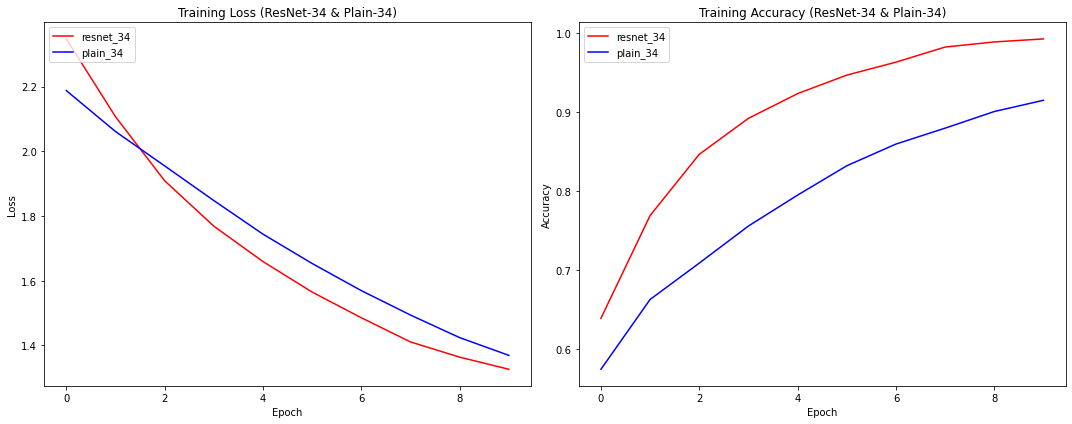

In [40]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Training Loss (ResNet-34 & Plain-34)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-34 & Plain-34)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01//Training_Loss_and_Accuracy_of_34.png')

plt.show()

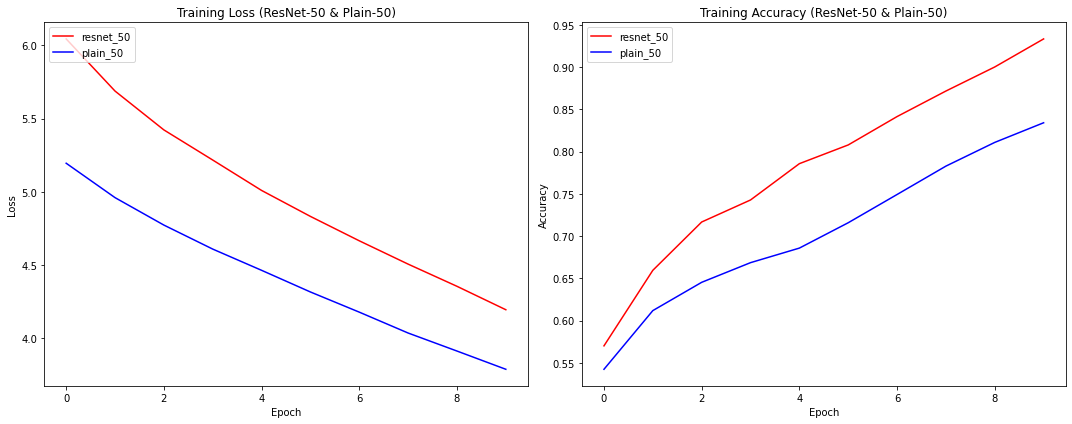

In [41]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Training Loss (ResNet-50 & Plain-50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('Training Accuracy (ResNet-50 & Plain-50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Training_Loss_and_Accuracy_of_50.png')

plt.show()

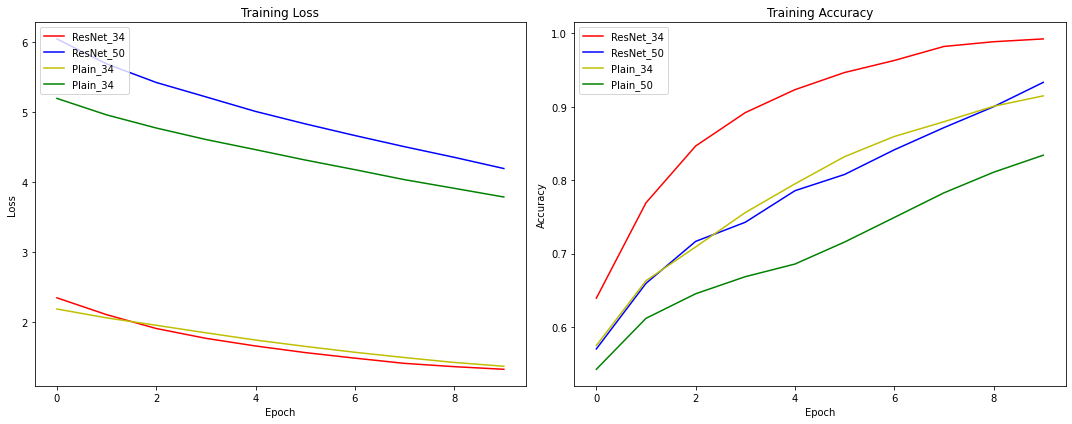

In [42]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Training Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Training_Loss_and_Accuracy_of_All.png')

plt.show()

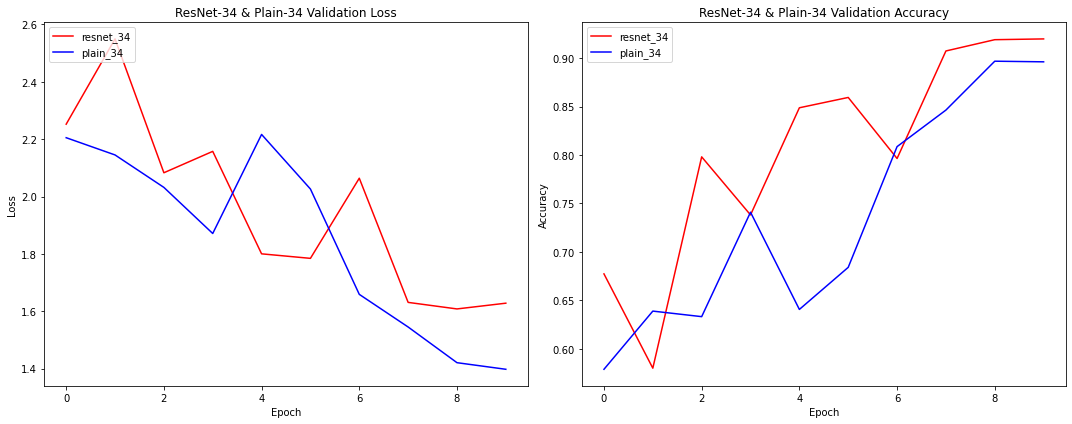

In [43]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

# ResNet-34, Plain-34 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Validation_Loss_and_Accuracy_of_34.png')

plt.show()

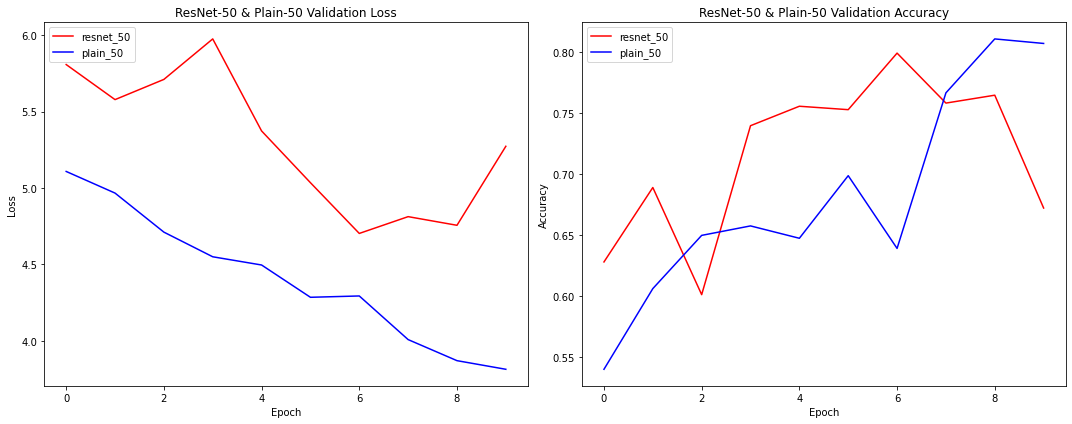

In [44]:
plt.subplots(figsize=(15,6))

# ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

# ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Validation_Loss_and_Accuracy_of_50.png')

plt.show()

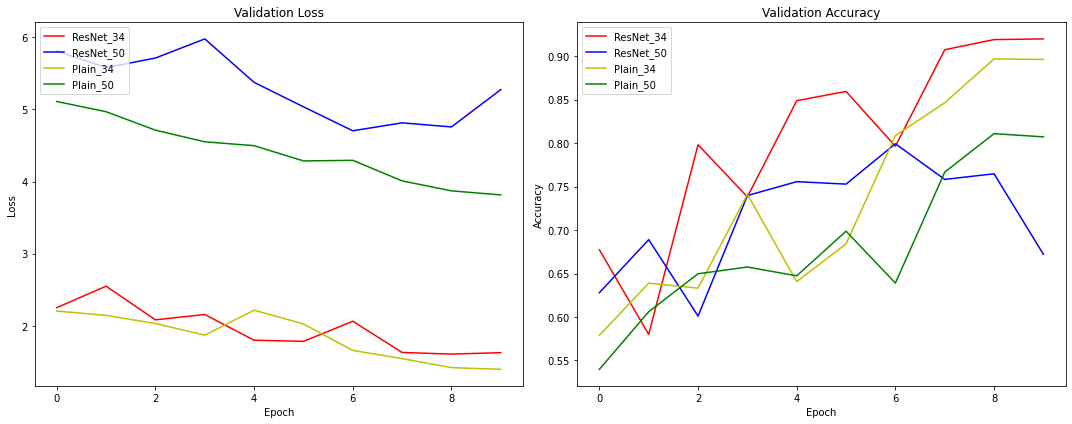

In [45]:
plt.subplots(figsize=(15,6))

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Loss 시각화
plt.subplot(121)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

# ResNet-34, Plain-34, ResNet-50, Plain-50 Validation Accuracy 시각화
plt.subplot(122)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')

plt.tight_layout()

# 시각화 저장
plt.savefig('/home/june/Github/GDCV/data/gd01/Validation_Loss_and_Accuracy_of_All.png')

plt.show()

In [46]:
# ResNet, Plain 학습 결과 평균값을 딕셔너리로 저장
model_result = {
    'ResNet-34': [
        round(np.array(history_resnet_34.history['loss']).mean(), 2),
        round(np.array(history_resnet_34.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_34.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_34.history['val_accuracy']).mean(), 2)
    ],
    'Plain-34': [
        round(np.array(history_plain_34.history['loss']).mean(), 2),
        round(np.array(history_plain_34.history['accuracy']).mean(), 2),
        round(np.array(history_plain_34.history['val_loss']).mean(), 2),
        round(np.array(history_plain_34.history['val_accuracy']).mean(), 2)
    ],
    'ResNet-50': [
        round(np.array(history_resnet_50.history['loss']).mean(), 2),
        round(np.array(history_resnet_50.history['accuracy']).mean(), 2),
        round(np.array(history_resnet_50.history['val_loss']).mean(), 2),
        round(np.array(history_resnet_50.history['val_accuracy']).mean(), 2)
    ],
    'Plain-50': [
        round(np.array(history_plain_50.history['loss']).mean(), 2),
        round(np.array(history_plain_50.history['accuracy']).mean(), 2),
        round(np.array(history_plain_50.history['val_loss']).mean(), 2),
        round(np.array(history_plain_50.history['val_accuracy']).mean(), 2)
    ],    
}

# 데이터 프레임 생성
df_model_result = pd.DataFrame(model_result, index=['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])
df_model_result

,ResNet-34,Plain-34,ResNet-50,Plain-50
Training Loss,1.69,1.73,4.99,4.42
Training Accuracy,0.89,0.79,0.78,0.70
Validation Loss,1.96,1.85,5.30,4.41
Validation Accuracy,0.80,0.74,0.72,0.68


In [47]:
df_val_acc = pd.DataFrame(df_model_result.loc['Validation Accuracy'], columns=['Validation Accuracy'])
df_val_acc

,Validation Accuracy
ResNet-34,0.80
Plain-34,0.74
ResNet-50,0.72
Plain-50,0.68


In [48]:
# ResNet-34, Plain-34, ResNet-50, Plain-50 학습 결과
df_model_result

,ResNet-34,Plain-34,ResNet-50,Plain-50
Training Loss,1.69,1.73,4.99,4.42
Training Accuracy,0.89,0.79,0.78,0.70
Validation Loss,1.96,1.85,5.30,4.41
Validation Accuracy,0.80,0.74,0.72,0.68


In [49]:
# Validation Accuracy 기준으로 결과 확인
df_val_acc

,Validation Accuracy
ResNet-34,0.80
Plain-34,0.74
ResNet-50,0.72
Plain-50,0.68


5) 루브릭

1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?

블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.


2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?

tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.
6) 회고

3. Ablation Study 결과가 바른 포맷으로 제출되었는가?

ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

6) 회고

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**